# Simple FEM for an elastic plate with a hole

Adapted from a [nutils example](https://github.com/evalf/nutils/blob/master/examples/platewithhole.py). The traction-free circle is
removed by means of the Finite Cell Method (FCM).

## Create a mesh for the plate with hole

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace

from global_constants import EPS0, LBD, MU, L, R

# Definitions
N = 20
deg = 2
ns = Namespace()
ns.δ = function.eye(2)
ns.lmbda = LBD
ns.mu = MU
ns.eps = L * EPS0

# Build geometry
domain0, geom = mesh.unitsquare(N, "square")
domain = domain0.trim(np.linalg.norm(geom) - R, maxrefine=2)

# Define the geometry variable x as well as gradients, normal and jacobians on the domain.
ns.x = geom
ns.define_for("x", gradient="∇", normal="n", jacobians=("dV", "dS"))

## Basis
A *nutils* basis is a vector-based function that evalautes at any given point $\mathbf{x}$ on the domain to the array of basis functions.

In [2]:
ns.basis = domain.basis("std", degree=deg).vector(2)

## Problem formulation

The weak form of the equation to be solved for the displacement field $\mathbf{u}: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ is 

$$ 
    \int_\Omega \sigma \cdot \nabla \mathbf{v} dV - \int_\Omega \mathbf{b} \cdot \mathbf{v} dV = 0
$$
with 
$$
\sigma = 2\mu \epsilon + \lambda \textrm{tr}(\epsilon) \mathbf{I}
$$
and
$$ 
    \varepsilon = \frac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right).
$$

In [3]:
ns.u = function.dotarg("lhs", ns.basis)
ns.strain_ij = "(∇_j(u_i) + ∇_i(u_j)) / 2"
ns.stress_ij = "lmbda strain_kk δ_ij + 2 mu strain_ij"
res = domain.integral("∇_j(basis_ni) stress_ij dV" @ ns, degree=deg * 2)

## Boundary conditions
The Dirichlet boundary conditions are expressed as 
$$ 
 \underset{\mathbf{u}}{\min} \int_{\partial\Omega} ( \mathbf{u} \cdot \mathbf{n})^2 dS = 0 \quad \text{at} \quad \partial\Omega_\text{left},\partial\Omega_\text{bottom}
$$
and 
$$ 
 \underset{\mathbf{u}}{\min} \int_{\partial\Omega} (u_1-\varepsilon_0 L)^2 dS = 0 \quad \text{at} \quad \partial\Omega_\text{right}.
$$

The remaining boundaries (hole and top) are natural boundaries without traction and hence do not require any definition in the code.

In [4]:
sqr = domain.boundary["left,bottom"].integral("(u_i n_i)^2 dS" @ ns, degree=deg * 2)
cons = solver.optimize("lhs", sqr, droptol=1e-15)
sqr = domain.boundary["right"].integral("(u_0 - eps)^2 dS" @ ns, degree=20)
cons = solver.optimize("lhs", sqr, droptol=1e-15, constrain=cons)

optimize > constrained 42/2810 dofs
optimize > optimum value 0.00e+00
optimize > solve > solving 41 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 2e-18
optimize > constrained 83/2810 dofs
optimize > optimum value -3.47e-18


## Solve the problem

In [5]:
lhs = solver.solve_linear("lhs", res, constrain=cons)

solve > solving 2727 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-15


## Visualization
The resulting vector is interpolated using beziers. It is plotted on the deformed domain $\mathbf{X} = \mathbf{x} + \mathbf{u}$.

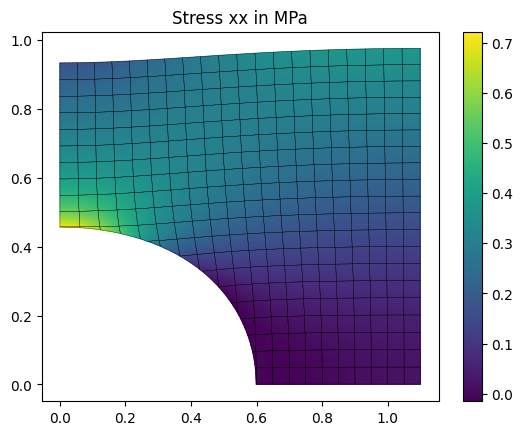

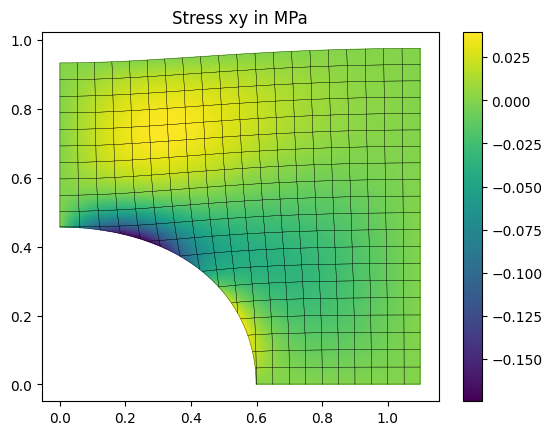

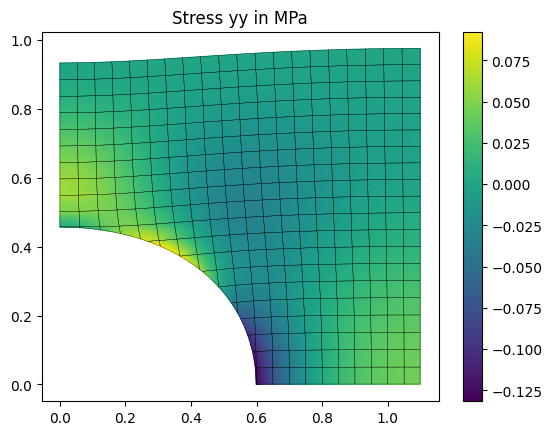

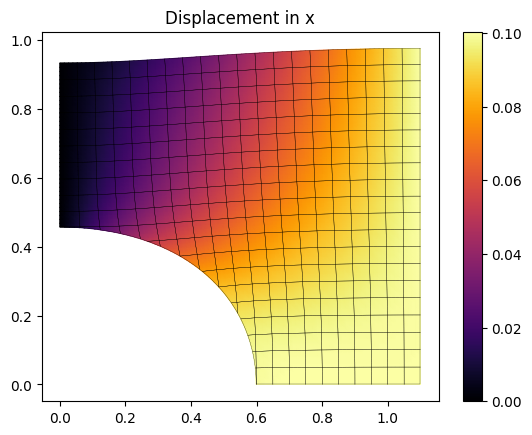

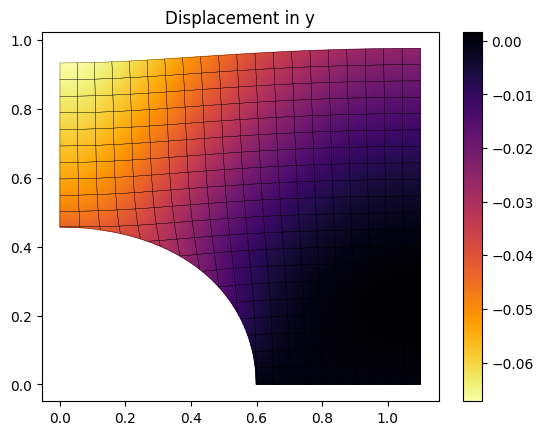

In [6]:
ns.X_i = "x_i + u_i"
bezier = domain.sample("bezier", 5)
X, sxx, sxy, syy, u, v = bezier.eval(
    ["X_i", "stress_00", "stress_01", "stress_11", "u_0", "u_1"] @ ns, lhs=lhs
)
gridlines = LineCollection(np.asarray(X.T).T[bezier.hull], colors="k", linewidths=0.2)

plt.tripcolor(*X.T, bezier.tri, sxx, shading="gouraud")
plt.gca().add_collection(copy(gridlines))
plt.colorbar()
plt.title("Stress xx in MPa")
plt.show()

plt.tripcolor(*X.T, bezier.tri, sxy, shading="gouraud")
plt.gca().add_collection(copy(gridlines))
plt.colorbar()
plt.title("Stress xy in MPa")
plt.show()

plt.tripcolor(*X.T, bezier.tri, syy, shading="gouraud")
plt.gca().add_collection(copy(gridlines))
plt.colorbar()
plt.title("Stress yy in MPa")
plt.show()

plt.tripcolor(*X.T, bezier.tri, u, shading="gouraud", cmap="inferno")
plt.gca().add_collection(copy(gridlines))
plt.colorbar()
plt.title("Displacement in x")
plt.show()

plt.tripcolor(*X.T, bezier.tri, v, shading="gouraud", cmap="inferno_r")
plt.gca().add_collection(copy(gridlines))
plt.colorbar()
plt.title("Displacement in y")
plt.show()